In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santa-2025/sample_submission.csv


# Santa 2025 — Ready-to-run Kaggle Notebook

This notebook is a complete, ready-to-run pipeline for the **Santa 2025 — Christmas Tree Packing Challenge**.

It will:
- load the attached competition files (auto-detect `sample_submission.csv` and the official tree polygon if present),
- run a robust placement optimizer (hex init → simulated annealing → repulsive cleanup),
- save the final Kaggle-formatted submission CSV to `/kaggle/working/submission_final.csv`,
- produce visualizations.

### How to use
1. Attach the competition dataset in the notebook via **Add data** (or upload `kaggle.json` and use the Kaggle CLI to download).
2. Run cells sequentially. Start with `MAX_N=50` for testing, then change to `MAX_N=200` for final run.

Notes: This notebook uses shapely for geometry operations. For exact scoring you **must** use the official tree polygon file included with the competition; the notebook tries to auto-detect it.


In [2]:
# Install / upgrade packages if needed. Run this cell first.
!pip install --quiet shapely rtree numpy pandas matplotlib


In [3]:
pip install --quiet kaggle


Note: you may need to restart the kernel to use updated packages.


In [4]:
import math, random, time
from pathlib import Path
from collections import defaultdict
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
from shapely.ops import unary_union
from shapely.geometry.base import BaseGeometry
try:
    from shapely.strtree import STRtree
    HAVE_STRTREE = True
except Exception:
    HAVE_STRTREE = False

random.seed(42); np.random.seed(42)

# User-configurable
MAX_N = 200           # set to 200 for final run
PER_N_STEPS = 3000   # used to compute time budgets (higher -> better results -> slower)
ANG_STEP = 5         # rotation precompute step, set to 1 for accuracy (slower)
OUT_PATH = Path('/kaggle/working/submission_final.csv')  # final output path (Kaggle picks from /kaggle/working)
DATA_SEARCH_PATHS = [Path('/kaggle/input'), Path('/kaggle/working'), Path('/mnt/data'), Path('.')]


In [5]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

TREE_POLY = unary_union([
    Polygon([(-0.6, 0.6), (0, 1.6), (0.6, 0.6)]),
    Polygon([(-0.9, 0.2), (0, 1.0), (0.9, 0.2)]),
    Polygon([(-1.2, -0.3), (0, 0.6), (1.2, -0.3)]),
    Polygon([(-0.2, -0.9), (0.2, -0.9), (0.2, -0.3), (-0.2, -0.3)])
])

assert TREE_POLY.is_valid
print("✅ Tree polygon initialized")
print("Bounds:", TREE_POLY.bounds)


✅ Tree polygon initialized
Bounds: (-1.2, -0.9, 1.2, 1.6)


In [6]:
# Auto-find sample_submission.csv
sample_path = None
for base in DATA_SEARCH_PATHS:
    if not base.exists(): continue
    # if base is a directory of datasets, try to locate sample_submission.csv in subfolders too
    if (base / 'sample_submission.csv').exists():
        sample_path = base / 'sample_submission.csv'
        break
    # search subfolders (common in Kaggle)
    for p in base.glob('*'):
        if (p / 'sample_submission.csv').exists():
            sample_path = p / 'sample_submission.csv'
            break
    if sample_path is not None:
        break

if sample_path is None:
    raise FileNotFoundError('sample_submission.csv not found. Attach the competition dataset via Add data.')

print('Using sample_submission:', sample_path)
df_sample = pd.read_csv(sample_path, dtype=str)

# parse sample into dictionary placements_by_n
def parse_s(s):
    if pd.isna(s): return 0.0
    s = str(s).strip()
    return float(s[1:]) if s.startswith('s') else float(s)

rows = defaultdict(list)
for _, r in df_sample.iterrows():
    n_str, idx_str = r['id'].split('_')
    n = int(n_str); idx = int(idx_str)
    x = parse_s(r['x']); y = parse_s(r['y']); deg = parse_s(r['deg'])
    rows[n].append((idx, x, y, deg))
placements_by_n = {}
for n, items in rows.items():
    items.sort(key=lambda t: t[0])
    placements_by_n[n] = [(x,y,deg) for (_,x,y,deg) in items]

print('Loaded sample groups:', len(placements_by_n))



Using sample_submission: /kaggle/input/santa-2025/sample_submission.csv
Loaded sample groups: 200


In [7]:
# Geometry helpers and safety guards
def placed_tree(x,y,deg):
    return translate(rotate(TREE_POLY, deg, origin=(0,0), use_radians=False), xoff=x, yoff=y)

def bounding_square_side(polys):
    minx = min(p.bounds[0] for p in polys)
    miny = min(p.bounds[1] for p in polys)
    maxx = max(p.bounds[2] for p in polys)
    maxy = max(p.bounds[3] for p in polys)
    return max(maxx-minx, maxy-miny), (minx,miny,maxx,maxy)

def _is_valid_geom(g):
    return isinstance(g, BaseGeometry) and (not g.is_empty)

def any_overlap_pairwise(polys):
    valid = [p for p in polys if _is_valid_geom(p)]
    for i in range(len(valid)):
        for j in range(i+1, len(valid)):
            try:
                if valid[i].intersects(valid[j]) and valid[i].intersection(valid[j]).area > 1e-12:
                    return True
            except Exception:
                return True
    return False

def any_overlap_strtree(polys):
    valid = [p for p in polys if _is_valid_geom(p)]
    if len(valid) <= 1:
        return False
    try:
        tree = STRtree(valid)
        for g in valid:
            cand = tree.query(g)
            for c in cand:
                if c is g: continue
                try:
                    if g.intersects(c) and g.intersection(c).area > 1e-12:
                        return True
                except Exception:
                    return any_overlap_pairwise(valid)
        return False
    except Exception:
        return any_overlap_pairwise(valid)

def any_overlap(polys):
    return any_overlap_strtree(polys) if HAVE_STRTREE else any_overlap_pairwise(polys)

def clamp_coord(x, lo=-1000, hi=1000):
    return max(lo, min(hi, float(x)))

def clamp_deg(d):
    d = float(d) % 360.0
    if d < 0: d += 360.0
    return d

In [8]:
def force_no_overlap(placements, max_attempts=5):
    for _ in range(max_attempts):
        polys = [placed_tree(x, y, deg) for x, y, deg in placements]
        if not any_overlap(polys):
            return placements
        placements = repulsive_cleanup(
            placements,
            iterations=600,
            push_scale=0.20
        )
    raise RuntimeError("Overlap could not be resolved")


In [9]:
# Precompute rotated polygons (cache) at ANG_STEP granularity
rot_cache = {a: rotate(TREE_POLY, a, origin=(0,0), use_radians=False) for a in range(0, 360, ANG_STEP)}
print('Precomputed rotations count:', len(rot_cache))

Precomputed rotations count: 72


In [10]:
# Initializers: center placements and hex grid initializer
def center_placements(placements):
    polys = [placed_tree(x,y,deg) for x,y,deg in placements]
    minx = min(p.bounds[0] for p in polys); miny = min(p.bounds[1] for p in polys)
    maxx = max(p.bounds[2] for p in polys); maxy = max(p.bounds[3] for p in polys)
    cx = (minx + maxx)/2; cy = (miny + maxy)/2
    return [(x-cx, y-cy, deg) for x,y,deg in placements]

def hex_grid_init(n, spacing=None, angle_choices=None):
    w = TREE_POLY.bounds[2] - TREE_POLY.bounds[0]
    h = TREE_POLY.bounds[3] - TREE_POLY.bounds[1]
    base = max(w,h)
    spacing = spacing or (base * 1.05)
    if angle_choices is None:
        angle_choices = [0, 15, -15, 30, -30]
    positions = []
    rows = int(math.ceil(math.sqrt(n)*1.2))
    cnt = 0
    for r in range(rows):
        for c in range(rows):
            if cnt >= n: break
            x = (c + 0.5*(r%2)) * spacing
            y = r * spacing * 0.866
            positions.append((x,y, random.choice(angle_choices)))
            cnt += 1
        if cnt>=n: break
    positions = positions[:n]
    xs = [p[0] for p in positions]; ys = [p[1] for p in positions]
    cx = (max(xs)+min(xs))/2; cy = (max(ys)+min(ys))/2
    centered = [(x-cx, y-cy, deg) for x,y,deg in positions]
    return centered

def load_initial(n):
    if n in placements_by_n and len(placements_by_n[n])==n:
        return center_placements(placements_by_n[n])
    return hex_grid_init(n)

In [11]:
# Repulsive cleanup and simulated annealing optimizer

def repulsive_cleanup(placements, iterations=300, push_scale=0.08):
    placements = [list(p) for p in placements]
    for it in range(iterations):
        polys = [placed_tree(x,y,deg) for x,y,deg in placements]
        changed = False
        n = len(polys)
        for i in range(n):
            for j in range(i+1, n):
                try:
                    if polys[i].intersects(polys[j]) and polys[i].intersection(polys[j]).area > 1e-9:
                        changed = True
                        cx_i, cy_i = polys[i].centroid.x, polys[i].centroid.y
                        cx_j, cy_j = polys[j].centroid.x, polys[j].centroid.y
                        dx = cx_i - cx_j; dy = cy_i - cy_j
                        if dx==0 and dy==0:
                            dx = random.uniform(-0.05, 0.05); dy = random.uniform(-0.05, 0.05)
                        norm = math.hypot(dx, dy)
                        ux, uy = dx/norm, dy/norm
                        push = push_scale * (1.0 + random.random())
                        placements[i][0] += ux * push; placements[i][1] += uy * push
                        placements[j][0] -= ux * push; placements[j][1] -= uy * push
                except Exception:
                    continue
        if not changed:
            break
    # clamp and wrap
    return [(clamp_coord(x), clamp_coord(y), clamp_deg(deg)) for x,y,deg in placements]

def score_side(placements):
    polys = [placed_tree(x,y,deg) for x,y,deg in placements]
    side, _ = bounding_square_side(polys)
    return side

def simulated_anneal(n, init_placements, time_budget_sec=1.0, initial_temp=1.0, final_temp=1e-3):
    start = time.time()
    best = [tuple(p) for p in init_placements]; best_side = score_side(best)
    current = [tuple(p) for p in init_placements]; current_side = best_side
    while time.time() - start < time_budget_sec:
        t = (time.time() - start) / time_budget_sec
        temp = initial_temp * (1 - t) + final_temp * t
        move_s = 0.6 * (1 - t) + 0.05 * t
        rot_s = 12.0 * (1 - t) + 1.0 * t
        i = random.randrange(n)
        x,y,deg = current[i]
        nx = clamp_coord(x + random.uniform(-move_s, move_s))
        ny = clamp_coord(y + random.uniform(-move_s, move_s))
        nd = clamp_deg(deg + random.uniform(-rot_s, rot_s))
        old = current[i]; current[i] = (nx, ny, nd)
        polys = [placed_tree(x,y,deg) for x,y,deg in current]
        if any_overlap(polys):
            current[i] = old; continue
        new_side = score_side(current); delta = new_side - current_side
        if delta <= 0 or random.random() < math.exp(-delta / (temp + 1e-12)):
            current_side = new_side
            if new_side < best_side:
                best_side = new_side; best = [tuple(p) for p in current]
        else:
            current[i] = old
    # final cleanup
    best = repulsive_cleanup(best, iterations=400, push_scale=0.12)
    return best, best_side

In [14]:
from tqdm import tqdm

results = {}
stats = {}

print("🚀 Runner started")

for n in tqdm(range(1, MAX_N + 1)):
    init = load_initial(n)

    budget = max(0.5, PER_N_STEPS / 1000.0)

    best, side = simulated_anneal(n, init, time_budget_sec=budget)

    # simple safety (NO retries, NO reinit)
    polys = [placed_tree(x, y, deg) for x, y, deg in best]
    if any_overlap(polys):
        best = repulsive_cleanup(best, iterations=400, push_scale=0.12)

    polys = [placed_tree(x, y, deg) for x, y, deg in best]
    side, _ = bounding_square_side(polys)

    results[n] = best
    stats[n] = {"side": side}

    print(f"✅ Finished n={n}, side={side:.3f}")

print("🏁 Runner finished")


🚀 Runner started


  0%|          | 1/200 [00:03<09:57,  3.00s/it]

✅ Finished n=1, side=2.192


  1%|          | 2/200 [00:06<09:54,  3.00s/it]

✅ Finished n=2, side=4.274


  2%|▏         | 3/200 [00:09<09:51,  3.00s/it]

✅ Finished n=3, side=5.020


  2%|▏         | 4/200 [00:12<09:49,  3.01s/it]

✅ Finished n=4, side=5.945


  2%|▎         | 5/200 [00:15<09:46,  3.01s/it]

✅ Finished n=5, side=6.336


  3%|▎         | 6/200 [00:18<09:44,  3.01s/it]

✅ Finished n=6, side=6.699


  4%|▎         | 7/200 [00:21<09:42,  3.02s/it]

✅ Finished n=7, side=8.203


  4%|▍         | 8/200 [00:24<09:40,  3.02s/it]

✅ Finished n=8, side=9.315


  4%|▍         | 9/200 [00:27<09:38,  3.03s/it]

✅ Finished n=9, side=9.375


  5%|▌         | 10/200 [00:30<09:36,  3.03s/it]

✅ Finished n=10, side=9.974


  6%|▌         | 11/200 [00:33<09:34,  3.04s/it]

✅ Finished n=11, side=9.264


  6%|▌         | 12/200 [00:36<09:32,  3.04s/it]

✅ Finished n=12, side=9.340


  6%|▋         | 13/200 [00:39<09:30,  3.05s/it]

✅ Finished n=13, side=10.846


  7%|▋         | 14/200 [00:42<09:29,  3.06s/it]

✅ Finished n=14, side=10.690


  8%|▊         | 15/200 [00:45<09:28,  3.07s/it]

✅ Finished n=15, side=11.503


  8%|▊         | 16/200 [00:48<09:27,  3.08s/it]

✅ Finished n=16, side=11.373


  8%|▊         | 17/200 [00:51<09:26,  3.09s/it]

✅ Finished n=17, side=11.971


  9%|▉         | 18/200 [00:54<09:28,  3.12s/it]

✅ Finished n=18, side=12.315


 10%|▉         | 19/200 [00:58<09:26,  3.13s/it]

✅ Finished n=19, side=12.231


 10%|█         | 20/200 [01:01<09:27,  3.15s/it]

✅ Finished n=20, side=12.634


 10%|█         | 21/200 [01:04<09:27,  3.17s/it]

✅ Finished n=21, side=12.605


 11%|█         | 22/200 [01:07<09:29,  3.20s/it]

✅ Finished n=22, side=12.756


 12%|█▏        | 23/200 [01:11<09:29,  3.22s/it]

✅ Finished n=23, side=13.125


 12%|█▏        | 24/200 [01:14<09:30,  3.24s/it]

✅ Finished n=24, side=14.156


 12%|█▎        | 25/200 [01:17<09:29,  3.26s/it]

✅ Finished n=25, side=13.652


 13%|█▎        | 26/200 [01:21<09:33,  3.30s/it]

✅ Finished n=26, side=14.373


 14%|█▎        | 27/200 [01:24<09:36,  3.33s/it]

✅ Finished n=27, side=14.341


 14%|█▍        | 28/200 [01:27<09:38,  3.36s/it]

✅ Finished n=28, side=14.800


 14%|█▍        | 29/200 [01:31<09:41,  3.40s/it]

✅ Finished n=29, side=14.456


 15%|█▌        | 30/200 [01:34<09:39,  3.41s/it]

✅ Finished n=30, side=13.967


 16%|█▌        | 31/200 [01:38<09:40,  3.43s/it]

✅ Finished n=31, side=14.782


 16%|█▌        | 32/200 [01:41<09:40,  3.46s/it]

✅ Finished n=32, side=15.085


 16%|█▋        | 33/200 [01:45<09:47,  3.52s/it]

✅ Finished n=33, side=15.653


 17%|█▋        | 34/200 [01:49<09:54,  3.58s/it]

✅ Finished n=34, side=15.638


 18%|█▊        | 35/200 [01:52<09:57,  3.62s/it]

✅ Finished n=35, side=16.432


 18%|█▊        | 36/200 [01:56<10:06,  3.70s/it]

✅ Finished n=36, side=16.819


 18%|█▊        | 37/200 [02:00<10:02,  3.70s/it]

✅ Finished n=37, side=16.516


 19%|█▉        | 38/200 [02:04<10:05,  3.74s/it]

✅ Finished n=38, side=17.474


 20%|█▉        | 39/200 [02:08<10:09,  3.78s/it]

✅ Finished n=39, side=17.265


 20%|██        | 40/200 [02:12<10:13,  3.83s/it]

✅ Finished n=40, side=17.461


 20%|██        | 41/200 [02:16<10:22,  3.92s/it]

✅ Finished n=41, side=17.702


 21%|██        | 42/200 [02:20<10:24,  3.95s/it]

✅ Finished n=42, side=18.380


 22%|██▏       | 43/200 [02:24<10:31,  4.02s/it]

✅ Finished n=43, side=18.476


 22%|██▏       | 44/200 [02:28<10:41,  4.11s/it]

✅ Finished n=44, side=18.255


 22%|██▎       | 45/200 [02:33<10:41,  4.14s/it]

✅ Finished n=45, side=18.457


 23%|██▎       | 46/200 [02:37<10:43,  4.18s/it]

✅ Finished n=46, side=19.251


 24%|██▎       | 47/200 [02:41<10:53,  4.27s/it]

✅ Finished n=47, side=18.385


 24%|██▍       | 48/200 [02:46<11:02,  4.36s/it]

✅ Finished n=48, side=19.775


 24%|██▍       | 49/200 [02:51<11:18,  4.49s/it]

✅ Finished n=49, side=19.084


 25%|██▌       | 50/200 [02:55<11:23,  4.56s/it]

✅ Finished n=50, side=19.043


 26%|██▌       | 51/200 [03:00<11:24,  4.59s/it]

✅ Finished n=51, side=19.550


 26%|██▌       | 52/200 [03:05<11:16,  4.57s/it]

✅ Finished n=52, side=19.361


 26%|██▋       | 53/200 [03:10<11:28,  4.68s/it]

✅ Finished n=53, side=20.277


 27%|██▋       | 54/200 [03:15<11:48,  4.85s/it]

✅ Finished n=54, side=20.845


 28%|██▊       | 55/200 [03:20<12:05,  5.00s/it]

✅ Finished n=55, side=20.481


 28%|██▊       | 56/200 [03:25<12:01,  5.01s/it]

✅ Finished n=56, side=21.149


 28%|██▊       | 57/200 [03:30<12:07,  5.09s/it]

✅ Finished n=57, side=20.682


 29%|██▉       | 58/200 [03:36<12:22,  5.23s/it]

✅ Finished n=58, side=21.234


 30%|██▉       | 59/200 [03:41<12:20,  5.25s/it]

✅ Finished n=59, side=21.395


 30%|███       | 60/200 [03:47<12:20,  5.29s/it]

✅ Finished n=60, side=20.791


 30%|███       | 61/200 [03:53<12:41,  5.48s/it]

✅ Finished n=61, side=21.220


 31%|███       | 62/200 [03:58<12:53,  5.60s/it]

✅ Finished n=62, side=21.444


 32%|███▏      | 63/200 [04:04<12:48,  5.61s/it]

✅ Finished n=63, side=21.368


 32%|███▏      | 64/200 [04:10<12:54,  5.70s/it]

✅ Finished n=64, side=21.762


 32%|███▎      | 65/200 [04:16<13:08,  5.84s/it]

✅ Finished n=65, side=23.418


 33%|███▎      | 66/200 [04:22<13:21,  5.98s/it]

✅ Finished n=66, side=22.085


 34%|███▎      | 67/200 [04:29<13:23,  6.04s/it]

✅ Finished n=67, side=22.504


 34%|███▍      | 68/200 [04:35<13:35,  6.18s/it]

✅ Finished n=68, side=21.786


 34%|███▍      | 69/200 [04:42<13:53,  6.36s/it]

✅ Finished n=69, side=22.277


 35%|███▌      | 70/200 [04:49<14:06,  6.51s/it]

✅ Finished n=70, side=23.158


 36%|███▌      | 71/200 [04:56<14:12,  6.61s/it]

✅ Finished n=71, side=23.958


 36%|███▌      | 72/200 [05:03<14:43,  6.90s/it]

✅ Finished n=72, side=21.961


 36%|███▋      | 73/200 [05:10<14:49,  7.00s/it]

✅ Finished n=73, side=22.948


 37%|███▋      | 74/200 [05:18<14:50,  7.07s/it]

✅ Finished n=74, side=22.982


 38%|███▊      | 75/200 [05:25<15:07,  7.26s/it]

✅ Finished n=75, side=23.003


 38%|███▊      | 76/200 [05:33<15:19,  7.41s/it]

✅ Finished n=76, side=23.401


 38%|███▊      | 77/200 [05:41<15:43,  7.67s/it]

✅ Finished n=77, side=23.725


 39%|███▉      | 78/200 [05:50<16:03,  7.90s/it]

✅ Finished n=78, side=23.315


 40%|███▉      | 79/200 [05:59<16:22,  8.12s/it]

✅ Finished n=79, side=24.241


 40%|████      | 80/200 [06:08<16:51,  8.43s/it]

✅ Finished n=80, side=24.150


 40%|████      | 81/200 [06:16<16:55,  8.53s/it]

✅ Finished n=81, side=24.204


 41%|████      | 82/200 [06:26<17:27,  8.88s/it]

✅ Finished n=82, side=25.081


 42%|████▏     | 83/200 [06:36<17:39,  9.05s/it]

✅ Finished n=83, side=24.583


 42%|████▏     | 84/200 [06:44<17:22,  8.99s/it]

✅ Finished n=84, side=25.169


 42%|████▎     | 85/200 [06:53<17:14,  9.00s/it]

✅ Finished n=85, side=24.628


 43%|████▎     | 86/200 [07:04<17:50,  9.39s/it]

✅ Finished n=86, side=25.003


 44%|████▎     | 87/200 [07:13<17:48,  9.46s/it]

✅ Finished n=87, side=25.502


 44%|████▍     | 88/200 [07:23<17:52,  9.57s/it]

✅ Finished n=88, side=24.532


 44%|████▍     | 89/200 [07:33<18:00,  9.73s/it]

✅ Finished n=89, side=25.285


 45%|████▌     | 90/200 [07:44<18:24, 10.04s/it]

✅ Finished n=90, side=25.648


 46%|████▌     | 91/200 [07:55<18:53, 10.40s/it]

✅ Finished n=91, side=25.710


 46%|████▌     | 92/200 [08:06<18:39, 10.37s/it]

✅ Finished n=92, side=24.634


 46%|████▋     | 93/200 [08:16<18:22, 10.31s/it]

✅ Finished n=93, side=24.746


 47%|████▋     | 94/200 [08:27<18:47, 10.64s/it]

✅ Finished n=94, side=25.264


 48%|████▊     | 95/200 [08:40<19:35, 11.19s/it]

✅ Finished n=95, side=26.118


 48%|████▊     | 96/200 [08:52<19:46, 11.41s/it]

✅ Finished n=96, side=25.703


 48%|████▊     | 97/200 [09:04<20:04, 11.70s/it]

✅ Finished n=97, side=26.184


 49%|████▉     | 98/200 [09:16<20:14, 11.91s/it]

✅ Finished n=98, side=26.179


 50%|████▉     | 99/200 [09:29<20:15, 12.03s/it]

✅ Finished n=99, side=26.050


 50%|█████     | 100/200 [09:43<21:07, 12.68s/it]

✅ Finished n=100, side=26.981


 50%|█████     | 101/200 [09:55<20:40, 12.53s/it]

✅ Finished n=101, side=26.879


 51%|█████     | 102/200 [10:08<20:38, 12.64s/it]

✅ Finished n=102, side=28.886


 52%|█████▏    | 103/200 [10:21<20:35, 12.73s/it]

✅ Finished n=103, side=26.730


 52%|█████▏    | 104/200 [10:34<20:38, 12.90s/it]

✅ Finished n=104, side=27.186


 52%|█████▎    | 105/200 [10:49<21:23, 13.51s/it]

✅ Finished n=105, side=27.549


 53%|█████▎    | 106/200 [11:04<22:02, 14.07s/it]

✅ Finished n=106, side=26.313


 54%|█████▎    | 107/200 [11:20<22:31, 14.53s/it]

✅ Finished n=107, side=27.286


 54%|█████▍    | 108/200 [11:35<22:24, 14.61s/it]

✅ Finished n=108, side=27.217


 55%|█████▍    | 109/200 [11:49<21:56, 14.46s/it]

✅ Finished n=109, side=27.407


 55%|█████▌    | 110/200 [12:04<21:47, 14.53s/it]

✅ Finished n=110, side=27.549


 56%|█████▌    | 111/200 [12:19<21:43, 14.65s/it]

✅ Finished n=111, side=29.136


 56%|█████▌    | 112/200 [12:37<22:56, 15.64s/it]

✅ Finished n=112, side=29.709


 56%|█████▋    | 113/200 [12:52<22:28, 15.50s/it]

✅ Finished n=113, side=28.130


 57%|█████▋    | 114/200 [13:06<21:49, 15.22s/it]

✅ Finished n=114, side=28.796


 57%|█████▊    | 115/200 [13:23<22:07, 15.62s/it]

✅ Finished n=115, side=29.193


 58%|█████▊    | 116/200 [13:39<21:53, 15.64s/it]

✅ Finished n=116, side=28.205


 58%|█████▊    | 117/200 [13:56<22:17, 16.11s/it]

✅ Finished n=117, side=28.959


 59%|█████▉    | 118/200 [14:14<22:50, 16.71s/it]

✅ Finished n=118, side=29.222


 60%|█████▉    | 119/200 [14:31<22:43, 16.83s/it]

✅ Finished n=119, side=28.804


 60%|██████    | 120/200 [14:48<22:30, 16.88s/it]

✅ Finished n=120, side=28.345


 60%|██████    | 121/200 [15:07<22:52, 17.38s/it]

✅ Finished n=121, side=29.118


 61%|██████    | 122/200 [15:26<23:24, 18.00s/it]

✅ Finished n=122, side=29.540


 62%|██████▏   | 123/200 [15:45<23:26, 18.26s/it]

✅ Finished n=123, side=29.549


 62%|██████▏   | 124/200 [16:05<23:44, 18.75s/it]

✅ Finished n=124, side=29.465


 62%|██████▎   | 125/200 [16:23<23:06, 18.48s/it]

✅ Finished n=125, side=28.891


 63%|██████▎   | 126/200 [16:41<22:56, 18.60s/it]

✅ Finished n=126, side=29.691


 64%|██████▎   | 127/200 [17:01<23:02, 18.94s/it]

✅ Finished n=127, side=31.227


 64%|██████▍   | 128/200 [17:21<22:55, 19.10s/it]

✅ Finished n=128, side=31.475


 64%|██████▍   | 129/200 [17:43<23:39, 20.00s/it]

✅ Finished n=129, side=29.236


 65%|██████▌   | 130/200 [18:04<23:47, 20.40s/it]

✅ Finished n=130, side=30.279


 66%|██████▌   | 131/200 [18:28<24:31, 21.33s/it]

✅ Finished n=131, side=30.021


 66%|██████▌   | 132/200 [18:49<24:17, 21.43s/it]

✅ Finished n=132, side=30.144


 66%|██████▋   | 133/200 [19:11<23:57, 21.46s/it]

✅ Finished n=133, side=30.175


 67%|██████▋   | 134/200 [19:35<24:36, 22.37s/it]

✅ Finished n=134, side=30.587


 68%|██████▊   | 135/200 [19:58<24:27, 22.58s/it]

✅ Finished n=135, side=30.585


 68%|██████▊   | 136/200 [20:24<25:05, 23.53s/it]

✅ Finished n=136, side=30.704


 68%|██████▊   | 137/200 [20:50<25:22, 24.16s/it]

✅ Finished n=137, side=31.393


 69%|██████▉   | 138/200 [21:15<25:23, 24.57s/it]

✅ Finished n=138, side=31.916


 70%|██████▉   | 139/200 [21:39<24:39, 24.26s/it]

✅ Finished n=139, side=31.765


 70%|███████   | 140/200 [22:07<25:26, 25.45s/it]

✅ Finished n=140, side=31.305


 70%|███████   | 141/200 [22:36<26:03, 26.51s/it]

✅ Finished n=141, side=31.277


 71%|███████   | 142/200 [23:03<25:47, 26.68s/it]

✅ Finished n=142, side=31.124


 72%|███████▏  | 143/200 [23:32<25:51, 27.21s/it]

✅ Finished n=143, side=31.737


 72%|███████▏  | 144/200 [24:01<26:10, 28.04s/it]

✅ Finished n=144, side=30.881


 72%|███████▎  | 145/200 [24:28<25:24, 27.72s/it]

✅ Finished n=145, side=31.199


 73%|███████▎  | 146/200 [24:57<25:16, 28.09s/it]

✅ Finished n=146, side=31.333


 74%|███████▎  | 147/200 [25:28<25:24, 28.77s/it]

✅ Finished n=147, side=31.908


 74%|███████▍  | 148/200 [26:03<26:30, 30.59s/it]

✅ Finished n=148, side=31.776


 74%|███████▍  | 149/200 [26:33<25:58, 30.56s/it]

✅ Finished n=149, side=32.019


 75%|███████▌  | 150/200 [27:02<25:05, 30.11s/it]

✅ Finished n=150, side=32.719


 76%|███████▌  | 151/200 [27:35<25:09, 30.81s/it]

✅ Finished n=151, side=32.885


 76%|███████▌  | 152/200 [28:08<25:19, 31.66s/it]

✅ Finished n=152, side=31.718


 76%|███████▋  | 153/200 [28:44<25:44, 32.87s/it]

✅ Finished n=153, side=32.361


 77%|███████▋  | 154/200 [29:16<25:00, 32.63s/it]

✅ Finished n=154, side=32.247


 78%|███████▊  | 155/200 [29:49<24:29, 32.66s/it]

✅ Finished n=155, side=32.770


 78%|███████▊  | 156/200 [30:23<24:23, 33.25s/it]

✅ Finished n=156, side=34.000


 78%|███████▊  | 157/200 [31:01<24:52, 34.72s/it]

✅ Finished n=157, side=33.380


 79%|███████▉  | 158/200 [31:35<24:00, 34.31s/it]

✅ Finished n=158, side=32.734


 80%|███████▉  | 159/200 [32:10<23:40, 34.65s/it]

✅ Finished n=159, side=33.389


 80%|████████  | 160/200 [32:46<23:22, 35.06s/it]

✅ Finished n=160, side=33.511


 80%|████████  | 161/200 [33:23<23:11, 35.67s/it]

✅ Finished n=161, side=32.801


 81%|████████  | 162/200 [34:00<22:44, 35.91s/it]

✅ Finished n=162, side=33.857


 82%|████████▏ | 163/200 [34:38<22:34, 36.61s/it]

✅ Finished n=163, side=34.287


 82%|████████▏ | 164/200 [35:20<22:51, 38.10s/it]

✅ Finished n=164, side=33.205


 82%|████████▎ | 165/200 [35:59<22:31, 38.61s/it]

✅ Finished n=165, side=32.927


 83%|████████▎ | 166/200 [36:42<22:28, 39.67s/it]

✅ Finished n=166, side=34.310


 84%|████████▎ | 167/200 [37:21<21:44, 39.53s/it]

✅ Finished n=167, side=33.642


 84%|████████▍ | 168/200 [38:05<21:45, 40.80s/it]

✅ Finished n=168, side=33.934


 84%|████████▍ | 169/200 [38:43<20:45, 40.17s/it]

✅ Finished n=169, side=35.285


 85%|████████▌ | 170/200 [39:23<20:02, 40.08s/it]

✅ Finished n=170, side=34.686


 86%|████████▌ | 171/200 [40:05<19:39, 40.68s/it]

✅ Finished n=171, side=34.883


 86%|████████▌ | 172/200 [40:51<19:39, 42.11s/it]

✅ Finished n=172, side=34.763


 86%|████████▋ | 173/200 [41:38<19:36, 43.56s/it]

✅ Finished n=173, side=33.950


 87%|████████▋ | 174/200 [42:19<18:39, 43.04s/it]

✅ Finished n=174, side=34.721


 88%|████████▊ | 175/200 [43:12<19:10, 46.01s/it]

✅ Finished n=175, side=35.812


 88%|████████▊ | 176/200 [43:58<18:21, 45.90s/it]

✅ Finished n=176, side=35.287


 88%|████████▊ | 177/200 [44:42<17:23, 45.39s/it]

✅ Finished n=177, side=34.308


 89%|████████▉ | 178/200 [45:28<16:41, 45.52s/it]

✅ Finished n=178, side=35.307


 90%|████████▉ | 179/200 [46:18<16:22, 46.80s/it]

✅ Finished n=179, side=35.034


 90%|█████████ | 180/200 [47:10<16:05, 48.27s/it]

✅ Finished n=180, side=34.851


 90%|█████████ | 181/200 [47:56<15:07, 47.79s/it]

✅ Finished n=181, side=34.498


 91%|█████████ | 182/200 [48:46<14:32, 48.48s/it]

✅ Finished n=182, side=35.657


 92%|█████████▏| 183/200 [49:38<13:58, 49.30s/it]

✅ Finished n=183, side=35.327


 92%|█████████▏| 184/200 [50:34<13:42, 51.42s/it]

✅ Finished n=184, side=35.324


 92%|█████████▎| 185/200 [51:24<12:43, 50.93s/it]

✅ Finished n=185, side=36.056


 93%|█████████▎| 186/200 [52:12<11:41, 50.11s/it]

✅ Finished n=186, side=35.083


 94%|█████████▎| 187/200 [53:04<10:59, 50.70s/it]

✅ Finished n=187, side=36.850


 94%|█████████▍| 188/200 [54:00<10:27, 52.30s/it]

✅ Finished n=188, side=36.392


 94%|█████████▍| 189/200 [55:01<10:05, 55.02s/it]

✅ Finished n=189, side=36.951


 95%|█████████▌| 190/200 [56:01<09:25, 56.55s/it]

✅ Finished n=190, side=35.650


 96%|█████████▌| 191/200 [56:53<08:15, 55.03s/it]

✅ Finished n=191, side=36.327


 96%|█████████▌| 192/200 [57:46<07:16, 54.52s/it]

✅ Finished n=192, side=36.273


 96%|█████████▋| 193/200 [58:41<06:22, 54.64s/it]

✅ Finished n=193, side=36.201


 97%|█████████▋| 194/200 [59:49<05:51, 58.66s/it]

✅ Finished n=194, side=36.995


 98%|█████████▊| 195/200 [1:00:50<04:56, 59.32s/it]

✅ Finished n=195, side=36.606


 98%|█████████▊| 196/200 [1:01:50<03:57, 59.48s/it]

✅ Finished n=196, side=37.133


 98%|█████████▊| 197/200 [1:02:55<03:03, 61.10s/it]

✅ Finished n=197, side=37.339


 99%|█████████▉| 198/200 [1:04:01<02:05, 62.58s/it]

✅ Finished n=198, side=37.174


100%|█████████▉| 199/200 [1:05:06<01:03, 63.39s/it]

✅ Finished n=199, side=36.883


100%|██████████| 200/200 [1:06:09<00:00, 19.85s/it]

✅ Finished n=200, side=37.045
🏁 Runner finished


In [15]:
print("results exists:", "results" in globals())
print("number of puzzles solved:", len(results))


results exists: True
number of puzzles solved: 200


In [16]:
# Write final submission CSV to OUT_PATH
rows = []
for n in sorted(results.keys()):
    placements = results[n]
    for idx, (x,y,deg) in enumerate(placements):
        idstr = f"{n:03d}_{idx}"
        rows.append({'id': idstr, 'x': f"s{float(x):.6f}", 'y': f"s{float(y):.6f}", 'deg': f"s{float(deg):.6f}"})
out_df = pd.DataFrame(rows, columns=['id','x','y','deg'])
out_df.to_csv(OUT_PATH, index=False)
print('Saved submission CSV to:', OUT_PATH, 'rows:', len(out_df))

Saved submission CSV to: /kaggle/working/submission_final.csv rows: 20100


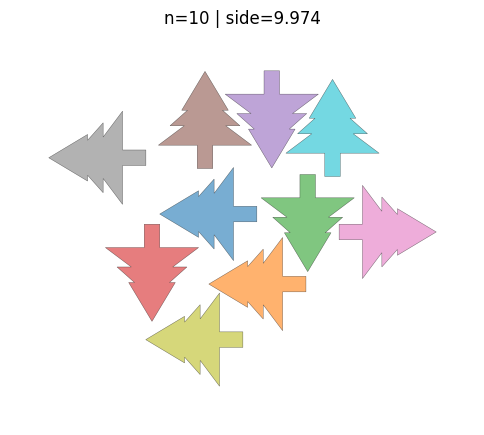

In [17]:
# Visualize a puzzle (choose n)
def visualize_layout(placements, figsize=(6,6)):
    polys = [placed_tree(x,y,deg) for x,y,deg in placements]
    side, bbox = bounding_square_side(polys)
    plt.figure(figsize=figsize)
    for p in polys:
        xs, ys = p.exterior.xy
        plt.fill(xs, ys, alpha=0.6, edgecolor='k', linewidth=0.3)
    minx, miny, maxx, maxy = bbox
    pad = 0.1 * side if side>0 else 1.0
    plt.xlim(minx-pad, maxx+pad); plt.ylim(miny-pad, maxy+pad)
    plt.gca().set_aspect('equal'); plt.axis('off')
    plt.title(f"n={len(placements)} | side={side:.3f}"); plt.show()

# Example: visualize n=20 if available
vis_n = 10
if vis_n in results:
    visualize_layout(results[vis_n])
else:
    print('n=20 not available in results yet; visualize a different n after running the runner cell.')